# Finetuning moondream

This notebook demonstrates how to fine-tune moondream to improve performance on a downstream task.
For this example, we'll fine-tune on this [Captcha image dataset](https://huggingface.co/datasets/project-sloth/captcha-images).

The first step is to construct a dataset split into `train`, `validation`, and `test` sets. This is
not strictly necessary and can be skipped if you're fine-tuning on a very small amount of data. We
will train the model on the `train` set, use the `validation` set to tune hyperparameters and prevent
overfitting, and finally evaluate the model on the `test` set.

In [ ]:
%pip install torch transformers timm einops datasets bitsandbytes

In [1]:
from torch.utils.data import Dataset
from datasets import load_dataset

class CaptchaDataset(Dataset):
    def __init__(self, split='train'):
        self.data = load_dataset(
            "project-sloth/captcha-images",
            revision="refs/convert/parquet",
        )[split]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return {
            "image": sample["image"], # Should be a PIL image
            "qa": [
                {
                    "question": "What does the text say?",
                    "answer": sample["solution"],
                }
            ]
        }

datasets = {
    "train": CaptchaDataset("train"),
    "val": CaptchaDataset("validation"),
    "test": CaptchaDataset("test"),
}

/home/vikhyat/IdealWaffle/moondream/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

In [2]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-03-13"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    attn_implementation="flash_attention_2" if DEVICE == "cuda" else None,
    torch_dtype=DTYPE, device_map={"": DEVICE}
).eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


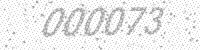

Question: What does the text say?
Ground Truth: 000073
Moondream: The text says "number 0073" on a white background.


In [3]:
from IPython.display import display

sample = datasets['train'][0]
display(sample['image'])

for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    print('Moondream:', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

Let's start setting up hyperparameters for finetuning.

In [4]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 1

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory. Batch size 4 currently uses around
# 21 GB of GPU memory during fine-tuning.
BATCH_SIZE = 4

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 2

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 4e-5


In [5]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from bitsandbytes.optim import Adam8bit
import math

# The current version of moondream uses "<END>" to denote the end of a response. In the future this
# will be replaced with a special token.
ANSWER_EOS = "<END>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}<END>",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images,
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder(images)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1) / 0.5)) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    ),
    "val": DataLoader(
        datasets["val"],
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn,
    ),
    "test": DataLoader(
        datasets["test"],
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn,
    ),
}

total_steps = EPOCHS * len(dataloaders["train"]) // (BATCH_SIZE * GRAD_ACCUM_STEPS)
optimizer = Adam8bit(moondream.text_model.parameters(), lr=LR * 0.1, betas=(0.9, 0.95), eps=1e-6)


In [6]:
from tqdm import tqdm

stats = {
    "loss/train": [],
    "loss/val": [],
    "lr": []
}

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        loss = compute_loss(batch)
        loss.backward()

        stats["loss/train"].append(loss.item())
        stats["lr"].append(optimizer.param_groups[0]['lr'])

        if (i + 1) % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            optimizer.param_groups[0]['lr'] = lr

        i += 1

Epoch 1/1: 100%|██████████| 1500/1500 [14:25<00:00,  1.73it/s]


Now that training has completed, let's save the updated text model, see how to load it, and try it out on some examples.

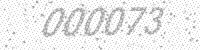

Question: What does the text say?
Ground Truth: 000073
Moondream: 000073


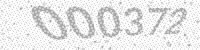

Question: What does the text say?
Ground Truth: 000372
Moondream: 000372


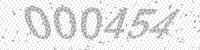

Question: What does the text say?
Ground Truth: 000454
Moondream: 000454


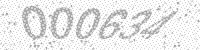

Question: What does the text say?
Ground Truth: 000634
Moondream: 006034


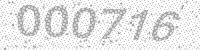

Question: What does the text say?
Ground Truth: 000716
Moondream: 000016


In [7]:
for i in range(5):
    sample = datasets['train'][i]
    display(sample['image'])

    for qa in sample['qa']:
        print('Question:', qa['question'])
        print('Ground Truth:', qa['answer'])
        print('Moondream:', moondream.answer_question(
            moondream.encode_image(sample['image']),
            qa['question'],
            tokenizer=tokenizer,
        ))